This notebook performs basic preprocessing for the wayback scraped listings. It also sets up intermediate files required calling GeoCode API via Open Route Service. The results from running this notebook are saved to `data/processed/domain/wayback_listings.csv`

# Data Preprocessing and Imputation

In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd
import glob
import os
import sys
from pathlib import Path
from shapely.geometry import Point

# Add project root to Python path
# Get the current notebook's directory and go up to project root
current_dir = Path().resolve()
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
elif current_dir.name == 'project2':
    project_root = current_dir
else:
    # If we're in the parent directory, look for project2
    project_root = current_dir / 'project2'

sys.path.insert(0, str(project_root))
print(f"Project root: {project_root}")

from utils.preprocess import PreprocessUtils
from utils.geo import GeoUtils

# Initialize the preprocessor
preprocessor = PreprocessUtils()

# Initialize the geo utils
geo_utils = GeoUtils()


OpenRouteService client initialized successfully.


In [91]:
# Define the path to the domain folder
domain_path = "../data/raw/domain"

# Get all CSV files except rental_listings_2025_09.csv
csv_files = glob.glob(os.path.join(domain_path, "rental_listings_*.csv"))
csv_files = [f for f in csv_files if "rental_listings_2025_09.csv" not in f]

print(f"Found {len(csv_files)} files to process:")
for f in sorted(csv_files):
    print(f"  - {os.path.basename(f)}")


Found 14 files to process:
  - rental_listings_2022_03.csv
  - rental_listings_2022_06.csv
  - rental_listings_2022_09.csv
  - rental_listings_2022_12.csv
  - rental_listings_2023_03.csv
  - rental_listings_2023_06.csv
  - rental_listings_2023_09.csv
  - rental_listings_2023_12.csv
  - rental_listings_2024_03.csv
  - rental_listings_2024_06.csv
  - rental_listings_2024_09.csv
  - rental_listings_2024_12.csv
  - rental_listings_2025_03.csv
  - rental_listings_2025_06.csv


Here we make the assumption that the listings on wayback have an `updated_dated` that is equal to the `scraped_date`. Because we scraped a random day with an existing snapshot for each suburb in each quarter going back to 2022 Q1, we essentially have more rental price data for listings last updated in the "past".

In [92]:
# Read all CSV files and add year and quarter columns
dataframes = []

for csv_file in sorted(csv_files):
    # Extract filename without extension
    filename = os.path.basename(csv_file)
    # Parse filename: rental_listings_YYYY_MM.csv
    parts = filename.replace('.csv', '').split('_')
    year = parts[2]
    month = parts[3]
    
    # Map month to quarter
    month_to_quarter = {
        '03': 1,
        '06': 2,
        '09': 3,
        '12': 4
    }
    quarter = month_to_quarter.get(month, 'Unknown')
    
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Add year and quarter columns
    df['year'] = int(year)
    df['quarter'] = quarter
    
    dataframes.append(df)
    print(f"Loaded {filename}: {len(df)} rows, Year={year}, Quarter={quarter}")

print(f"\nTotal dataframes loaded: {len(dataframes)}")


Loaded rental_listings_2022_03.csv: 20 rows, Year=2022, Quarter=1


Loaded rental_listings_2022_06.csv: 3047 rows, Year=2022, Quarter=2
Loaded rental_listings_2022_09.csv: 710 rows, Year=2022, Quarter=3
Loaded rental_listings_2022_12.csv: 23 rows, Year=2022, Quarter=4
Loaded rental_listings_2023_03.csv: 123 rows, Year=2023, Quarter=1
Loaded rental_listings_2023_06.csv: 98 rows, Year=2023, Quarter=2
Loaded rental_listings_2023_09.csv: 20 rows, Year=2023, Quarter=3
Loaded rental_listings_2023_12.csv: 179 rows, Year=2023, Quarter=4
Loaded rental_listings_2024_03.csv: 1372 rows, Year=2024, Quarter=1
Loaded rental_listings_2024_06.csv: 1786 rows, Year=2024, Quarter=2
Loaded rental_listings_2024_09.csv: 1460 rows, Year=2024, Quarter=3
Loaded rental_listings_2024_12.csv: 1562 rows, Year=2024, Quarter=4
Loaded rental_listings_2025_03.csv: 3340 rows, Year=2025, Quarter=1
Loaded rental_listings_2025_06.csv: 3382 rows, Year=2025, Quarter=2

Total dataframes loaded: 14


In [93]:
# Stack all dataframes together
df = pd.concat(dataframes, ignore_index=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17122 entries, 0 to 17121
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   property_id        17122 non-null  int64  
 1   url                17122 non-null  object 
 2   rental_price       17122 non-null  object 
 3   bedrooms           16994 non-null  float64
 4   bathrooms          17067 non-null  float64
 5   car_spaces         15120 non-null  float64
 6   property_type      17122 non-null  object 
 7   land_area          17122 non-null  float64
 8   property_features  17122 non-null  object 
 9   suburb             17122 non-null  object 
 10  postcode           17122 non-null  int64  
 11  scraped_date       17122 non-null  object 
 12  wayback_url        17122 non-null  object 
 13  wayback_time       17122 non-null  int64  
 14  year               17122 non-null  int64  
 15  quarter            17122 non-null  int64  
dtypes: float64(4), int64(5

In [94]:
# Map the suburbs to standardized names (used by DFFH dataset)
df['suburb'] = preprocessor.map_suburb(df['suburb'])

# Remove the suburbs that have count less than 10
suburb_counts = df['suburb'].value_counts()
valid_suburbs = suburb_counts[suburb_counts > 10].index
df = df[df['suburb'].isin(valid_suburbs)]

df['suburb'].nunique()

338

In [68]:
# drop land_area column
df = df.drop(columns=['land_area'])

# convert bedrooms, bathrooms, car_spaces to Int64
df['bedrooms'] = df['bedrooms'].astype('Int64')
df['bathrooms'] = df['bathrooms'].astype('Int64')
df['car_spaces'] = df['car_spaces'].astype('Int64')


In [69]:
# impute bedrooms, bathrooms, car_spaces with preprocessor
# handle missing values by imputing by mode grouped by property_type
print("Before imputation:")
print(df[['bedrooms', 'bathrooms', 'car_spaces']].isnull().sum())

# Impute bedrooms using property_type mode
df['bedrooms'] = preprocessor.impute_by_property_type_mode(df, 'bedrooms')

# Impute bathrooms using property_type mode
df['bathrooms'] = preprocessor.impute_by_property_type_mode(df, 'bathrooms')

# Impute car_spaces using property_type mode
df['car_spaces'] = preprocessor.impute_by_property_type_mode(df, 'car_spaces')

print("\nAfter imputation:")
print(df[['bedrooms', 'bathrooms', 'car_spaces']].isnull().sum())

Before imputation:
bedrooms       108
bathrooms       42
car_spaces    1767
dtype: int64
Property type: Apartment / Unit / Flat, bedrooms imputed with 2
Property type: Townhouse, bedrooms imputed with 3
Property type: House, bedrooms imputed with 3
Property type: Studio, bedrooms imputed with 1
Property type: Duplex, bedrooms imputed with 2
Property type: Vacant land, bedrooms imputed with 4
Property type: Farm, bedrooms imputed with <NA>
Property type: Apartment / Unit / Flat, bathrooms imputed with 1
Property type: Townhouse, bathrooms imputed with 2
Property type: House, bathrooms imputed with 2
Property type: Studio, bathrooms imputed with 1
Property type: Vacant land, bathrooms imputed with 2
Property type: Farm, bathrooms imputed with <NA>
Property type: Apartment / Unit / Flat, car_spaces imputed with 1
Property type: Townhouse, car_spaces imputed with 2
Property type: House, car_spaces imputed with 2
Property type: Studio, car_spaces imputed with 1
Property type: New Apartments

In [70]:
# Extract weekly rent from rental_price column
df['rental_price'] = preprocessor.extract_rental_price(df['rental_price'])

# Check how many rows have unknown frequencies (NaN in weekly_rent)
unknown_count = df['rental_price'].isna().sum()
print(f"Rows with unknown price frequencies: {unknown_count}")

# Drop rows with unknown frequencies
df = df[df['rental_price'].notna()]

Rows with unknown price frequencies: 351


In [71]:
# extract address from url since we don't have the address in the summary listing data
df['address'] = df['url'].apply(geo_utils.extract_address_from_url)

# drop url column
df = df.drop(columns=['url', 'property_features', 'postcode', 'scraped_date', 'wayback_url', 'wayback_time'])

df

,property_id,rental_price,bedrooms,bathrooms,car_spaces,property_type,suburb,year,quarter,address
0,15295193,240.0,1,1,1,Apartment / Unit / Flat,footscray,2022,1,"51 Gordon Street, Footscray, VIC 3011"
1,15624467,385.0,2,1,1,Townhouse,footscray,2022,1,"Cirque Drive, Footscray, VIC 3011"
2,15726089,470.0,2,1,1,House,footscray,2022,1,"10 Stanlake Street, Footscray, VIC 3011"
3,15754757,410.0,2,1,1,Apartment / Unit / Flat,footscray,2022,1,"42 Whitehall Street, Footscray, VIC 3011"
4,15802091,650.0,3,2,2,House,footscray,2022,1,"2 Saltriver Place, Footscray, VIC 3011"
...,...,...,...,...,...,...,...,...,...,...
17113,13001612,70.0,1,1,3,House,trafalgar,2025,2,"1c Dodemaides, Trafalgar, VIC 3824"
17115,17530473,340.0,1,1,2,Studio,trafalgar,2025,2,"26a Waterloo Road, Trafalgar, VIC 3824"
17116,17597533,500.0,3,1,2,House,trafalgar,2025,2,"Princes Way, Trafalgar, VIC 3824"
17120,17618453,550.0,3,2,2,House,trafalgar,2025,2,"Cross Street, Trafalgar, VIC 3824"


In [72]:
# check for property_id duplicates
df['property_id'].duplicated().sum()

# sort by year, quarter descending
df = df.sort_values(by=['year', 'quarter'], ascending=False)

# drop duplicates but keep first occurrence
df = df.drop_duplicates(subset=['property_id'], keep='first')

df.shape




(14044, 10)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14044 entries, 13740 to 19
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_id    14044 non-null  int64  
 1   rental_price   14044 non-null  float64
 2   bedrooms       14043 non-null  Int64  
 3   bathrooms      14043 non-null  Int64  
 4   car_spaces     14043 non-null  Int64  
 5   property_type  14044 non-null  object 
 6   suburb         14044 non-null  object 
 7   year           14044 non-null  int64  
 8   quarter        14044 non-null  int64  
 9   address        14044 non-null  object 
dtypes: Int64(3), float64(1), int64(3), object(3)
memory usage: 1.2+ MB


In [74]:
# drop remaining nulls
df = df.dropna()

df.info()

df.shape


<class 'pandas.core.frame.DataFrame'>
Index: 14043 entries, 13740 to 19
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_id    14043 non-null  int64  
 1   rental_price   14043 non-null  float64
 2   bedrooms       14043 non-null  Int64  
 3   bathrooms      14043 non-null  Int64  
 4   car_spaces     14043 non-null  Int64  
 5   property_type  14043 non-null  object 
 6   suburb         14043 non-null  object 
 7   year           14043 non-null  int64  
 8   quarter        14043 non-null  int64  
 9   address        14043 non-null  object 
dtypes: Int64(3), float64(1), int64(3), object(3)
memory usage: 1.2+ MB


(14043, 10)

In [75]:
# save to data/processed/domain/wayback_listings.csv
df.to_csv("../data/processed/domain/wayback_listings.csv", index=False)

# Fetching Coordinates/ Geocoding the Address of Wayback Listings

We need to geocode the address to get the latitude and longitude. Let us first save the listings to `data/raw/missing_coordinates`. This way we know which listings still need to be geocoded. We will be using the Open Route Service Geocode API which has an API request limit of 1000 per key. 

In [76]:
# Split the dataframe into batches and save to output directory
output_dir = "../data/raw/missing_coordinates"
batch_size = 1000

batch_files = preprocessor.split_into_batches(df[['property_id', 'address']], batch_size, output_dir)
print(f"\nCreated {len(batch_files)} batch files")


Saved batch_0001.csv: 1000 rows
Saved batch_0002.csv: 1000 rows
Saved batch_0003.csv: 1000 rows
Saved batch_0004.csv: 1000 rows
Saved batch_0005.csv: 1000 rows
Saved batch_0006.csv: 1000 rows
Saved batch_0007.csv: 1000 rows
Saved batch_0008.csv: 1000 rows
Saved batch_0009.csv: 1000 rows
Saved batch_0010.csv: 1000 rows
Saved batch_0011.csv: 1000 rows
Saved batch_0012.csv: 1000 rows
Saved batch_0013.csv: 1000 rows
Saved batch_0014.csv: 1000 rows
Saved batch_0015.csv: 43 rows

Total batches created: 15
Output directory: ../data/raw/missing_coordinates

Created 15 batch files


After setting up the input files, we can now run the script from the project `/` directory `./run_geocode.sh`. This should then create 15 files in `data/processed/coordinates`.

In [77]:
# read in all the csv in data/processed/coordinates and stack into single dataframe
df_coordinates = preprocessor.merge_batches("../data/processed/coordinates", pattern="batch_*.csv",verbose=True)

# drop rows where geocode_success is False
df_coordinates = df_coordinates[df_coordinates['geocode_success']]

# drop the geocode_success column
df_coordinates = df_coordinates.drop(columns=['geocode_success'])

# drop the address column
df_coordinates = df_coordinates.drop(columns=['address'])

# fix the order of coordinates
# convert longitude and latitude to Point
df_coordinates['coordinates'] = df_coordinates.apply(lambda row: Point(row['latitude'], row['longitude']), axis=1)

print(df_coordinates.shape)
# save to data/processed/coordinates/geocoded_listings.csv
df_coordinates.to_csv("../data/processed/coordinates/geocoded_wayback_listings.csv", index=False)

Starting merge process...
Input directory: ../data/processed/coordinates
File pattern: batch_*.csv
------------------------------------------------------------
Found 16 files to merge:
  - batch_0001_geocoded.csv
  - batch_0002_geocoded.csv
  - batch_0003_geocoded.csv
  - batch_0004_geocoded.csv
  - batch_0005_geocoded.csv
  - batch_0006_geocoded.csv
  - batch_0007_geocoded.csv
  - batch_0008_geocoded.csv
  - batch_0009_geocoded.csv
  - batch_0010_geocoded.csv
  - batch_0011_geocoded.csv
  - batch_0012_geocoded.csv
  - batch_0013_geocoded.csv
  - batch_0014_geocoded.csv
  - batch_0015_geocoded.csv
  - batch_0016_geocoded.csv

  Loaded: batch_0001_geocoded.csv (1,000 rows)
  Loaded: batch_0002_geocoded.csv (1,000 rows)
  Loaded: batch_0003_geocoded.csv (1,000 rows)
  Loaded: batch_0004_geocoded.csv (1,000 rows)
  Loaded: batch_0005_geocoded.csv (1,000 rows)
  Loaded: batch_0006_geocoded.csv (1,000 rows)
  Loaded: batch_0007_geocoded.csv (1,000 rows)
  Loaded: batch_0008_geocoded.csv (1,

In [78]:
df_coordinates

,property_id,longitude,latitude,coordinates
0,15295193,144.889952,-37.791139,POINT (-37.791139 144.889952)
1,15624467,144.896622,-37.798680,POINT (-37.79868 144.896622)
2,15726089,144.884333,-37.791939,POINT (-37.791939 144.884333)
3,15754757,144.905187,-37.802479,POINT (-37.802479 144.905187)
4,15802091,144.908234,-37.801644,POINT (-37.801644 144.908234)
...,...,...,...,...
14299,13001612,146.146464,-38.209552,POINT (-38.209552 146.146464)
14300,17530473,146.147961,-38.207978,POINT (-38.207978 146.147961)
14301,17597533,146.154994,-38.211812,POINT (-38.211812 146.154994)
14302,17618453,146.157027,-38.216646,POINT (-38.216646 146.157027)


# Combining Live Listings with Wayback Listings

In [ ]:
# read in live listings from data/processed/domain/live_listings.csv
live_listings = pd.read_csv("../data/processed/domain/live_listings.csv")

# drop the coordinates column from live_listings
live_listings = live_listings.drop(columns=['coordinates'])

# save to data/processed/domain/live_listings.csv



In [139]:

# read in wayback listings from data/processed/domain/wayback_listings.csv
wayback_listings = pd.read_csv("../data/processed/domain/wayback_listings.csv")

# merge wayback_listings with df_coordinates on property_id
wayback_listings = wayback_listings.merge(df_coordinates, on='property_id', how='left')

# drop the rows where coordinates is None
wayback_listings = wayback_listings[wayback_listings['coordinates'].notna()]

# drop address column
wayback_listings = wayback_listings.drop(columns=['address'])

wayback_listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13301 entries, 176 to 15280
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_id    13301 non-null  int64  
 1   rental_price   13301 non-null  float64
 2   bedrooms       13301 non-null  int64  
 3   bathrooms      13301 non-null  int64  
 4   car_spaces     13301 non-null  int64  
 5   property_type  13301 non-null  object 
 6   suburb         13301 non-null  object 
 7   year           13301 non-null  int64  
 8   quarter        13301 non-null  int64  
 9   longitude      13301 non-null  float64
 10  latitude       13301 non-null  float64
 11  coordinates    13301 non-null  object 
dtypes: float64(3), int64(6), object(3)
memory usage: 1.3+ MB


In [81]:
# stack live_listings and wayback_listings summary data
live_listings = live_listings[wayback_listings.columns]
# concat live_listings and wayback_listings 
df = pd.concat([live_listings, wayback_listings])

In [82]:
# sort by year, quarter descending
df = df.sort_values(by=['year', 'quarter'], ascending=False)

# drop duplicates but keep first occurrence
df = df.drop_duplicates(subset=['property_id'], keep='first')

# convert property_id to int64
df["property_id"] = df["property_id"].astype("Int64")

# save to data/processed/domain/cleaned_listings.csv
df.to_csv("../data/processed/domain/cleaned_listings.csv", index=False)



# Isochrones

In [ ]:
# read in data/processed/poi_features/

# Stratified Sampling

Randomly shuffle and stratify sample the dataframe down to 50% by property_type, suburb, and bedrooms. This helps reduce computational cost while maintaining representative distribution of property characteristics.


In [83]:
# Set random seed for reproducibility
import numpy as np
np.random.seed(42)

# First, shuffle the dataframe randomly
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Create stratification groups based on property_type, suburb, and bedrooms
df_shuffled['strata'] = (
    df_shuffled['property_type'].astype(str) + '_' + 
    df_shuffled['suburb'].astype(str) + '_' + 
    df_shuffled['bedrooms'].astype(str)
)

# Perform stratified sampling to get 50% of the data
df_sampled = df_shuffled.groupby('strata', group_keys=False).apply(
    lambda x: x.sample(frac=0.5, random_state=42) if len(x) > 1 else x
)

# Drop the temporary strata column
df_sampled = df_sampled.drop(columns=['strata'])

# Reset index
df_sampled = df_sampled.reset_index(drop=True)

print(f"Original size: {len(df_shuffled):,} rows")
print(f"Sampled size: {len(df_sampled):,} rows")
print(f"Sampling ratio: {len(df_sampled) / len(df_shuffled):.1%}")

# Verify distribution is maintained
print("\n--- Property Type Distribution ---")
print("Original:")
print(df_shuffled['property_type'].value_counts(normalize=True).head())
print("\nSampled:")
print(df_sampled['property_type'].value_counts(normalize=True).head())

print("\n--- Bedrooms Distribution ---")
print("Original:")
print(df_shuffled['bedrooms'].value_counts(normalize=True).sort_index())
print("\nSampled:")
print(df_sampled['bedrooms'].value_counts(normalize=True).sort_index())


Original size: 24,517 rows
Sampled size: 13,101 rows
Sampling ratio: 53.4%

--- Property Type Distribution ---
Original:
property_type
house                      0.256597
House                      0.253253
apartment / unit / flat    0.195905
Apartment / Unit / Flat    0.167680
Townhouse                  0.056736
Name: proportion, dtype: float64

Sampled:
property_type
house                      0.251279
House                      0.250897
apartment / unit / flat    0.190214
Apartment / Unit / Flat    0.166094
Townhouse                  0.061140
Name: proportion, dtype: float64

--- Bedrooms Distribution ---
Original:
bedrooms
1     0.135946
2     0.288983
3     0.333442
4     0.218746
5     0.019660
6     0.001999
7     0.000571
8     0.000367
9     0.000245
50    0.000041
Name: proportion, dtype: float64

Sampled:
bedrooms
1     0.138005
2     0.288909
3     0.325319
4     0.216472
5     0.025571
6     0.003511
7     0.001069
8     0.000611
9     0.000458
50    0.000076
Name: proport

/var/folders/xj/ny4zmnqd609bv2rpjzzr11rm0000gn/T/ipykernel_57411/3131207073.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_shuffled.groupby('strata', group_keys=False).apply(


In [84]:
# Save the sampled dataframe
df_sampled.to_csv("../data/processed/domain/cleaned_listings_sampled.csv", index=False)
print("\n✓ Saved stratified sampled data to: data/processed/domain/cleaned_listings_sampled.csv")



✓ Saved stratified sampled data to: data/processed/domain/cleaned_listings_sampled.csv


In [85]:
# Display summary statistics
print("Final sampled dataset:")
print(f"Shape: {df_sampled.shape}")
print(f"\nUnique suburbs: {df_sampled['suburb'].nunique()}")
print(f"Unique property types: {df_sampled['property_type'].nunique()}")
print(f"\nTop 10 suburbs by count:")
print(df_sampled['suburb'].value_counts().head(10))


Final sampled dataset:
Shape: (13101, 12)

Unique suburbs: 368
Unique property types: 24

Top 10 suburbs by count:
suburb
melbourne                         616
tarneit                           196
southbank                         191
werribee-hoppers crossing         189
south yarra                       157
north melbourne-west melbourne    155
truganina                         154
shepparton                        139
st kilda                          131
glen waverley-mulgrave            128
Name: count, dtype: int64


In [86]:
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13101 entries, 0 to 13100
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_id    13101 non-null  Int64  
 1   rental_price   13101 non-null  float64
 2   bedrooms       13101 non-null  int64  
 3   bathrooms      13101 non-null  int64  
 4   car_spaces     13101 non-null  int64  
 5   property_type  13101 non-null  object 
 6   suburb         13101 non-null  object 
 7   year           13101 non-null  int64  
 8   quarter        13101 non-null  int64  
 9   longitude      13101 non-null  float64
 10  latitude       13101 non-null  float64
 11  coordinates    13101 non-null  object 
dtypes: Int64(1), float64(3), int64(5), object(3)
memory usage: 1.2+ MB


In [132]:
# select the rows of df_sampled where property_id is in wayback_listings['property_id']
df_sampled_wayback = df_sampled[df_sampled['property_id'].isin(wayback_listings['property_id'])]

df_sampled_wayback.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6499 entries, 0 to 13051
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_id    6499 non-null   Int64  
 1   rental_price   6499 non-null   float64
 2   bedrooms       6499 non-null   int64  
 3   bathrooms      6499 non-null   int64  
 4   car_spaces     6499 non-null   int64  
 5   property_type  6499 non-null   object 
 6   suburb         6499 non-null   object 
 7   year           6499 non-null   int64  
 8   quarter        6499 non-null   int64  
 9   longitude      6499 non-null   float64
 10  latitude       6499 non-null   float64
 11  coordinates    6499 non-null   object 
dtypes: Int64(1), float64(3), int64(5), object(3)
memory usage: 666.4+ KB


In [88]:
batch_size = 500
for output_dir in ["../data/raw/missing_isochrones_wayback/driving", "../data/raw/missing_isochrones_wayback/walking", "../data/raw/missing_poi_wayback", "../data/raw/missing_routes_wayback"]:
    preprocessor.split_into_batches(df_sampled_wayback[['property_id', 'coordinates']], batch_size, output_dir)


Saved batch_0001.csv: 500 rows
Saved batch_0002.csv: 500 rows
Saved batch_0003.csv: 500 rows
Saved batch_0004.csv: 500 rows
Saved batch_0005.csv: 500 rows
Saved batch_0006.csv: 500 rows
Saved batch_0007.csv: 500 rows
Saved batch_0008.csv: 500 rows
Saved batch_0009.csv: 500 rows
Saved batch_0010.csv: 500 rows
Saved batch_0011.csv: 500 rows
Saved batch_0012.csv: 500 rows
Saved batch_0013.csv: 499 rows

Total batches created: 13
Output directory: ../data/raw/missing_isochrones_wayback/driving
Saved batch_0001.csv: 500 rows
Saved batch_0002.csv: 500 rows
Saved batch_0003.csv: 500 rows
Saved batch_0004.csv: 500 rows
Saved batch_0005.csv: 500 rows
Saved batch_0006.csv: 500 rows
Saved batch_0007.csv: 500 rows
Saved batch_0008.csv: 500 rows
Saved batch_0009.csv: 500 rows
Saved batch_0010.csv: 500 rows
Saved batch_0011.csv: 500 rows
Saved batch_0012.csv: 500 rows
Saved batch_0013.csv: 499 rows

Total batches created: 13
Output directory: ../data/raw/missing_isochrones_wayback/walking
Saved batc

After running `./run_isochrones_batch_walking.sh` and `./run_isochrones_batch_driving.sh`, we should be able to merge the resulting files created in the directory `data/processed/isochrones/walking` and `data/processed/isochrones/driving`

In [134]:
walking_isochrones = preprocessor.merge_batches("../data/processed/isochrones/walking", pattern="isochrone_00*.csv",verbose=True)
driving_isochrones = preprocessor.merge_batches("../data/processed/isochrones/driving", pattern="isochrone_00*.csv",verbose=True)

Starting merge process...
Input directory: ../data/processed/isochrones/walking
File pattern: isochrone_00*.csv
------------------------------------------------------------
Found 26 files to merge:
  - isochrone_0001.csv
  - isochrone_0002.csv
  - isochrone_0003.csv
  - isochrone_0004.csv
  - isochrone_0005.csv
  - isochrone_0006.csv
  - isochrone_0007.csv
  - isochrone_0008.csv
  - isochrone_0009.csv
  - isochrone_0010.csv
  - isochrone_0011.csv
  - isochrone_0012.csv
  - isochrone_0013.csv
  - isochrone_0014.csv
  - isochrone_0015.csv
  - isochrone_0016.csv
  - isochrone_0017.csv
  - isochrone_0018.csv
  - isochrone_0019.csv
  - isochrone_0020.csv
  - isochrone_0021.csv
  - isochrone_0022.csv
  - isochrone_0023.csv
  - isochrone_0024.csv
  - isochrone_0025.csv
  - isochrone_0026.csv

  Loaded: isochrone_0001.csv (500 rows)
  Loaded: isochrone_0002.csv (500 rows)
  Loaded: isochrone_0003.csv (500 rows)
  Loaded: isochrone_0004.csv (500 rows)
  Loaded: isochrone_0005.csv (500 rows)
  L

In [127]:
walking_isochrones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12648 entries, 0 to 12647
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   5min         7638 non-null   object 
 1   10min        7638 non-null   object 
 2   15min        7638 non-null   object 
 3   property_id  12648 non-null  float64
 4   coordinates  12648 non-null  object 
dtypes: float64(1), object(4)
memory usage: 494.2+ KB


In [128]:
driving_isochrones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   5min         4929 non-null   object 
 1   10min        4929 non-null   object 
 2   15min        4929 non-null   object 
 3   property_id  6499 non-null   float64
 4   coordinates  6499 non-null   object 
dtypes: float64(1), object(4)
memory usage: 254.0+ KB


In [135]:
# rename the columns of walking_isochrones to walking_5min, walking_10min, walking_15min
walking_isochrones.rename(columns={"5min": "walking_5min", "10min": "walking_10min", "15min": "walking_15min"}, inplace=True)

# rename the columns of driving_isochrones to driving_5min, driving_10min, driving_15min
driving_isochrones.rename(columns={"5min": "driving_5min", "10min": "driving_10min", "15min": "driving_15min"}, inplace=True)

# drop coordinates column from walking_isochrones and driving_isochrones
walking_isochrones = walking_isochrones.drop(columns=["coordinates"])
driving_isochrones = driving_isochrones.drop(columns=["coordinates"])

# merge the walking_isochrones, driving_isochrones dataframe with the df_sampled_wayback dataframe on property_id
df_sampled_wayback = df_sampled_wayback.merge(walking_isochrones, on="property_id", how="left")
df_sampled_wayback = df_sampled_wayback.merge(driving_isochrones, on="property_id", how="left")
df_sampled_wayback.head()

,property_id,rental_price,bedrooms,bathrooms,car_spaces,property_type,suburb,year,quarter,longitude,latitude,coordinates,walking_5min,walking_10min,walking_15min,driving_5min,driving_10min,driving_15min
0,17519803,1475.0,4,2,4,Acreage / Semi-Rural,balnarring,2025,2,145.156852,-38.338784,POINT (-38.338784 145.156852),"POLYGON ((145.148892 -38.338974, 145.151682 -3...","POLYGON ((145.146723 -38.338976, 145.148892 -3...","POLYGON ((145.14211 -38.338987, 145.14548 -38....","POLYGON ((145.09187 -38.340616, 145.097089 -38...","POLYGON ((145.051823 -38.35463, 145.05208 -38....","POLYGON ((145.005979 -38.337229, 145.011721 -3..."
1,16032533,900.0,4,2,4,Acreage / Semi-Rural,baxter,2024,3,145.181874,-38.199352,POINT (-38.199352 145.181874),"POLYGON ((145.177392 -38.198572, 145.180646 -3...","POLYGON ((145.172193 -38.197766, 145.17293 -38...","POLYGON ((145.167278 -38.197012, 145.170757 -3...","POLYGON ((145.150912 -38.177616, 145.15124 -38...","POLYGON ((145.101406 -38.225703, 145.107046 -3...","POLYGON ((145.06122 -38.223543, 145.062576 -38..."
2,14155100,1500.0,6,3,4,Acreage / Semi-Rural,bittern,2024,3,145.185613,-38.330202,POINT (-38.330202 145.185613),"POLYGON ((145.18239 -38.329807, 145.185138 -38...","POLYGON ((145.180147 -38.333169, 145.180434 -3...","POLYGON ((145.176482 -38.332827, 145.177262 -3...","POLYGON ((145.140831 -38.340612, 145.14302 -38...","POLYGON ((145.084541 -38.340612, 145.087083 -3...","POLYGON ((145.043508 -38.348152, 145.043742 -3..."
3,15947357,1500.0,4,2,5,Acreage / Semi-Rural,cranbourne south,2022,2,145.275799,-38.157937,POINT (-38.157937 145.275799),"POLYGON ((145.276367 -38.153869, 145.276276 -3...","POLYGON ((145.275499 -38.151654, 145.275769 -3...","POLYGON ((145.270793 -38.151067, 145.272236 -3...","POLYGON ((145.24063 -38.149058, 145.243134 -38...","POLYGON ((145.209834 -38.141493, 145.212036 -3...","POLYGON ((145.175865 -38.100352, 145.176223 -3..."
4,15872831,450.0,4,2,2,Acreage / Semi-Rural,diggers rest,2022,2,144.736734,-37.645999,POINT (-37.645999 144.736734),"POLYGON ((144.734556 -37.641985, 144.734602 -3...","POLYGON ((144.734558 -37.641889, 144.734556 -3...","POLYGON ((144.734558 -37.641889, 144.734556 -3...","POLYGON ((144.733008 -37.641417, 144.732984 -3...","POLYGON ((144.699478 -37.606545, 144.701009 -3...","POLYGON ((144.651311 -37.549646, 144.652891 -3..."


In [130]:
df_sampled_wayback.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6559 entries, 0 to 6558
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_id    6559 non-null   Int64  
 1   rental_price   6559 non-null   float64
 2   bedrooms       6559 non-null   int64  
 3   bathrooms      6559 non-null   int64  
 4   car_spaces     6559 non-null   int64  
 5   property_type  6559 non-null   object 
 6   suburb         6559 non-null   object 
 7   year           6559 non-null   int64  
 8   quarter        6559 non-null   int64  
 9   longitude      6559 non-null   float64
 10  latitude       6559 non-null   float64
 11  coordinates    6559 non-null   object 
 12  walking_5min   5644 non-null   object 
 13  walking_10min  5644 non-null   object 
 14  walking_15min  5644 non-null   object 
 15  driving_5min   4982 non-null   object 
 16  driving_10min  4982 non-null   object 
 17  driving_15min  4982 non-null   object 
dtypes: Int64

In [136]:
# impute the null values in the df_sampled_wayback dataframe
df_sampled_wayback[['walking_5min_imputed', 'walking_10min_imputed', 'walking_15min_imputed']] = preprocessor.impute_by_nearest_point(df_sampled_wayback, ["walking_5min", "walking_10min", "walking_15min"])
df_sampled_wayback[['driving_5min_imputed', 'driving_10min_imputed', 'driving_15min_imputed']] = preprocessor.impute_by_nearest_point(df_sampled_wayback, ["driving_5min", "driving_10min", "driving_15min"])
df_sampled_wayback.info()
# save to data/curated/rent_features/wayback_isochrones.csv
df_sampled_wayback.to_csv("../data/curated/rent_features/wayback_isochrones.csv", index=False)

df_sampled_wayback.head()


Imputing null values in 3 column(s): ['walking_5min', 'walking_10min', 'walking_15min']
Total rows with null values to impute: 915
Successfully imputed: 915 rows, Could not impute (no data available): 0
Imputing null values in 3 column(s): ['driving_5min', 'driving_10min', 'driving_15min']
Total rows with null values to impute: 1577
Successfully imputed: 1577 rows, Could not impute (no data available): 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6559 entries, 0 to 6558
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   property_id            6559 non-null   Int64  
 1   rental_price           6559 non-null   float64
 2   bedrooms               6559 non-null   int64  
 3   bathrooms              6559 non-null   int64  
 4   car_spaces             6559 non-null   int64  
 5   property_type          6559 non-null   object 
 6   suburb                 6559 non-null   object 
 7   year        

,property_id,rental_price,bedrooms,bathrooms,car_spaces,property_type,suburb,year,quarter,longitude,...,walking_15min,driving_5min,driving_10min,driving_15min,walking_5min_imputed,walking_10min_imputed,walking_15min_imputed,driving_5min_imputed,driving_10min_imputed,driving_15min_imputed
0,17519803,1475.0,4,2,4,Acreage / Semi-Rural,balnarring,2025,2,145.156852,...,"POLYGON ((145.14211 -38.338987, 145.14548 -38....","POLYGON ((145.09187 -38.340616, 145.097089 -38...","POLYGON ((145.051823 -38.35463, 145.05208 -38....","POLYGON ((145.005979 -38.337229, 145.011721 -3...","POLYGON ((145.148892 -38.338974, 145.151682 -3...","POLYGON ((145.146723 -38.338976, 145.148892 -3...","POLYGON ((145.14211 -38.338987, 145.14548 -38....","POLYGON ((145.09187 -38.340616, 145.097089 -38...","POLYGON ((145.051823 -38.35463, 145.05208 -38....","POLYGON ((145.005979 -38.337229, 145.011721 -3..."
1,16032533,900.0,4,2,4,Acreage / Semi-Rural,baxter,2024,3,145.181874,...,"POLYGON ((145.167278 -38.197012, 145.170757 -3...","POLYGON ((145.150912 -38.177616, 145.15124 -38...","POLYGON ((145.101406 -38.225703, 145.107046 -3...","POLYGON ((145.06122 -38.223543, 145.062576 -38...","POLYGON ((145.177392 -38.198572, 145.180646 -3...","POLYGON ((145.172193 -38.197766, 145.17293 -38...","POLYGON ((145.167278 -38.197012, 145.170757 -3...","POLYGON ((145.150912 -38.177616, 145.15124 -38...","POLYGON ((145.101406 -38.225703, 145.107046 -3...","POLYGON ((145.06122 -38.223543, 145.062576 -38..."
2,14155100,1500.0,6,3,4,Acreage / Semi-Rural,bittern,2024,3,145.185613,...,"POLYGON ((145.176482 -38.332827, 145.177262 -3...","POLYGON ((145.140831 -38.340612, 145.14302 -38...","POLYGON ((145.084541 -38.340612, 145.087083 -3...","POLYGON ((145.043508 -38.348152, 145.043742 -3...","POLYGON ((145.18239 -38.329807, 145.185138 -38...","POLYGON ((145.180147 -38.333169, 145.180434 -3...","POLYGON ((145.176482 -38.332827, 145.177262 -3...","POLYGON ((145.140831 -38.340612, 145.14302 -38...","POLYGON ((145.084541 -38.340612, 145.087083 -3...","POLYGON ((145.043508 -38.348152, 145.043742 -3..."
3,15947357,1500.0,4,2,5,Acreage / Semi-Rural,cranbourne south,2022,2,145.275799,...,"POLYGON ((145.270793 -38.151067, 145.272236 -3...","POLYGON ((145.24063 -38.149058, 145.243134 -38...","POLYGON ((145.209834 -38.141493, 145.212036 -3...","POLYGON ((145.175865 -38.100352, 145.176223 -3...","POLYGON ((145.276367 -38.153869, 145.276276 -3...","POLYGON ((145.275499 -38.151654, 145.275769 -3...","POLYGON ((145.270793 -38.151067, 145.272236 -3...","POLYGON ((145.24063 -38.149058, 145.243134 -38...","POLYGON ((145.209834 -38.141493, 145.212036 -3...","POLYGON ((145.175865 -38.100352, 145.176223 -3..."
4,15872831,450.0,4,2,2,Acreage / Semi-Rural,diggers rest,2022,2,144.736734,...,"POLYGON ((144.734558 -37.641889, 144.734556 -3...","POLYGON ((144.733008 -37.641417, 144.732984 -3...","POLYGON ((144.699478 -37.606545, 144.701009 -3...","POLYGON ((144.651311 -37.549646, 144.652891 -3...","POLYGON ((144.734556 -37.641985, 144.734602 -3...","POLYGON ((144.734558 -37.641889, 144.734556 -3...","POLYGON ((144.734558 -37.641889, 144.734556 -3...","POLYGON ((144.733008 -37.641417, 144.732984 -3...","POLYGON ((144.699478 -37.606545, 144.701009 -3...","POLYGON ((144.651311 -37.549646, 144.652891 -3..."


In [18]:
import pandas as pd

#  load in cleaned_listings
cleaned_listings = pd.read_csv("../data/processed/domain/cleaned_listings.csv")

cleaned_listings.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24517 entries, 0 to 24516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_id    24517 non-null  int64  
 1   rental_price   24517 non-null  float64
 2   bedrooms       24517 non-null  int64  
 3   bathrooms      24517 non-null  int64  
 4   car_spaces     24517 non-null  int64  
 5   property_type  24517 non-null  object 
 6   suburb         24517 non-null  object 
 7   year           24517 non-null  int64  
 8   quarter        24517 non-null  int64  
 9   longitude      24517 non-null  float64
 10  latitude       24517 non-null  float64
 11  coordinates    24517 non-null  object 
dtypes: float64(3), int64(6), object(3)
memory usage: 2.2+ MB


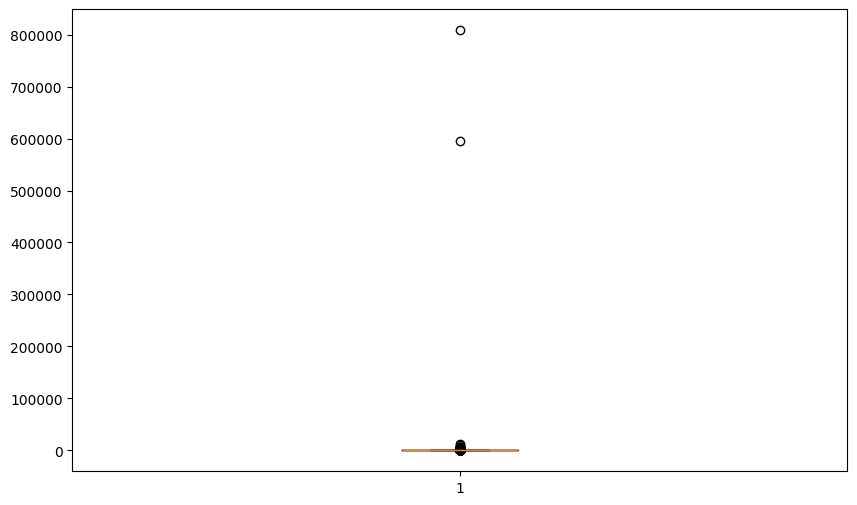

In [19]:
import matplotlib.pyplot as plt
# make a boxplot of rental_price
plt.figure(figsize=(10, 6))
plt.boxplot(cleaned_listings['rental_price'])
plt.show()


In [20]:
# show the values of the quantiles above 95%
print(cleaned_listings['rental_price'].quantile(0.99))
print(cleaned_listings['rental_price'].quantile(0.01))


1671.0000000000036
240.0


In [21]:
# remove outliers via IQR (0.25 and 0.75) rule for rental_price
cleaned_listings = cleaned_listings[cleaned_listings['rental_price'] < cleaned_listings['rental_price'].quantile(0.99)]
cleaned_listings = cleaned_listings[cleaned_listings['rental_price'] > cleaned_listings['rental_price'].quantile(0.01)]

cleaned_listings.info()



<class 'pandas.core.frame.DataFrame'>
Index: 24027 entries, 0 to 24516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_id    24027 non-null  int64  
 1   rental_price   24027 non-null  float64
 2   bedrooms       24027 non-null  int64  
 3   bathrooms      24027 non-null  int64  
 4   car_spaces     24027 non-null  int64  
 5   property_type  24027 non-null  object 
 6   suburb         24027 non-null  object 
 7   year           24027 non-null  int64  
 8   quarter        24027 non-null  int64  
 9   longitude      24027 non-null  float64
 10  latitude       24027 non-null  float64
 11  coordinates    24027 non-null  object 
dtypes: float64(3), int64(6), object(3)
memory usage: 2.4+ MB
